<a href="https://colab.research.google.com/github/namita0210/Text-Sentiment-Classifier/blob/main/colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
from kagglehub import dataset_download
import seaborn as sns
import joblib
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
import re
import numpy as np
from scipy.sparse import hstack
import string
from sklearn.preprocessing import StandardScaler
import nltk
from sklearn.decomposition import TruncatedSVD
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer as lemmy
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
#import tensorflow as tf
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Embedding, Dense, Flatten
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng') # It uses the perceptron algorithm to assign parts of speech to words based on context.
nltk.download('punkt') # for tokenizing text to words or sentences
nltk.download('stopwords') # populary removed words
nltk.download('wordnet') #dictionary of words to reduce them to their base form : lemmatize
nltk.download('averaged_perceptron_tagger')  # For POS tagging
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import Normalizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
print("Done")

C:\Users\nnn866470\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\nnn866470\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\nnn866470\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nnn866470\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nnn866470\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_dat

Done


In [46]:
# Download latest version
path = dataset_download("jp797498e/twitter-entity-sentiment-analysis")
print("Path to dataset files:", path)

Path to dataset files: C:\Users\nnn866470\.cache\kagglehub\datasets\jp797498e\twitter-entity-sentiment-analysis\versions\2


In [47]:
train_df = pd.read_csv(path + '/twitter_training.csv' , header = None)
val_df = pd.read_csv(path + '/twitter_validation.csv', header = None)
train_df.columns = ['id','title','sentiment','text']
val_df.columns = ['id','title','sentiment','text']

print(f'''Train Df Shape : {train_df.shape}
Validation Df Shape : {val_df.shape}''')

Train Df Shape : (74682, 4)
Validation Df Shape : (1000, 4)


In [48]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         74682 non-null  int64 
 1   title      74682 non-null  object
 2   sentiment  74682 non-null  object
 3   text       73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [49]:
nulls =74682-73996
nulls

686

A very small number of null values in a large dataset, so we can drop these rows.

In [50]:
train_df.dropna(subset=['text'], inplace=True)

In [51]:
train_df.head(2)

,id,title,sentiment,text
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...


In [52]:
val_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         1000 non-null   int64 
 1   title      1000 non-null   object
 2   sentiment  1000 non-null   object
 3   text       1000 non-null   object
dtypes: int64(1), object(3)
memory usage: 31.4+ KB


In [53]:
val_df.head(2)

,id,title,sentiment,text
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...


In [54]:
train_df['sentiment'].unique()

array(['Positive', 'Neutral', 'Negative', 'Irrelevant'], dtype=object)

Checking for class imbalance

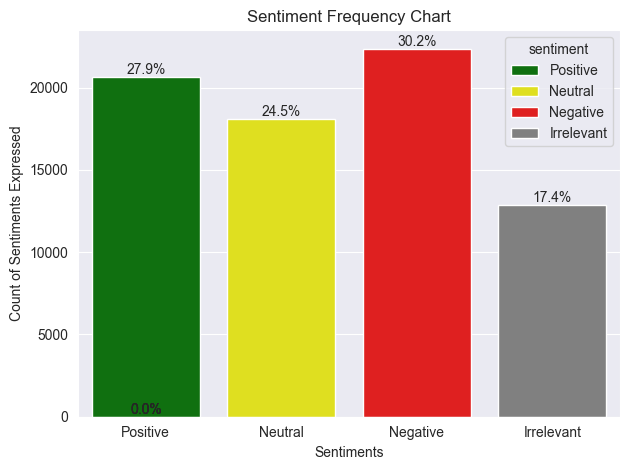

In [55]:
color = {'Positive':'Green', 'Neutral':'Yellow', 'Irrelevant':'Grey','Negative':'Red'}
ax = sns.countplot(x='sentiment', data=train_df
                   ,order=['Positive','Neutral','Negative','Irrelevant']
                  ,hue='sentiment'
                  ,legend=True
                  ,palette=color)
total = len(train_df['sentiment'])

for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='bottom')


plt.xlabel('Sentiments')
plt.ylabel('Count of Sentiments Expressed')
plt.title('Sentiment Frequency Chart')
plt.tight_layout()
plt.show()

There is a minimal class imbalance, so no need to go with resampling methods. We will use algorithms like Logistic Regression with balanced weights, random forest, and xgboost that work well with imbalance and we will evaluate with precision and recall to get a holistic evaluation which is not affected by the class imbalance

### Clean the Data

In [56]:
def clean(text):

    stop_words = set(stopwords.words('english')) #stopwords is a class whose object is words and english is it's argument which is stored in a variable called stop_words

    lm = lemmy() #lm is an instance of the lemmy() class
    text=text.lower() #lowercase

    no_punct = re.sub(r'[^a-z\s]','',text) #remove punctuation, digits

    words = word_tokenize(no_punct) #split text into words, returns a list

    words = [i for i in words if i not in stop_words] #remove stopwords

    pos_tags = nltk.pos_tag(words) # returns a tuple (word, pos tag)

    words = [
    lm.lemmatize(word, pos='v') if tag.startswith('V') else  # If tag starts with 'V', treat as verb
    lm.lemmatize(word, pos='n') if tag.startswith('N') else  # If tag starts with 'N', treat as noun
    lm.lemmatize(word, pos='a') if tag.startswith('R') else  # If tag starts with 'R', treat as adjective/adverb
    lm.lemmatize(word)  # Default to noun if no match
    for word, tag in pos_tags
    ] #lemmatize returns a string

    clean_words = ' '.join(words) # joins the words in the list seprated by a space

    return clean_words #This is a string.

In [57]:
train_df['text']=train_df['text'].apply(clean)

In [58]:
train_df.head()

,id,title,sentiment,text
0,2401,Borderlands,Positive,im get borderland murder
1,2401,Borderlands,Positive,come border kill
2,2401,Borderlands,Positive,im get borderland kill
3,2401,Borderlands,Positive,im come borderland murder
4,2401,Borderlands,Positive,im get borderland murder


### BOW

In [59]:
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import hstack
from category_encoders import TargetEncoder

In [60]:
# Step 1: Get the data and ensure proper tokenization
train_df = train_df.sample(frac=1) # Shuffle the data

In [61]:
bow_test = val_df.head(10) # It has the target column
bow_train = train_df.head(20)

In [62]:
bow_test.head(3)

,id,title,sentiment,text
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...


In [87]:
y_real_bow = val_df['sentiment']

In [64]:
bow_train['sentiment'].unique()

array(['Irrelevant', 'Positive', 'Neutral', 'Negative'], dtype=object)

In [65]:
bow_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20 entries, 36016 to 50168
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         20 non-null     int64 
 1   title      20 non-null     object
 2   sentiment  20 non-null     object
 3   text       20 non-null     object
dtypes: int64(1), object(3)
memory usage: 800.0+ bytes


In [66]:
target_encoder = TargetEncoder()

In [67]:
# Step 3 - Vectorization
#bow_train.loc[:, 'text_joined'] = bow_train['text'].str.join(' ') # Join tokens back into strings (required by CountVectorizer)
vectorizer = CountVectorizer()
X_bow = vectorizer.fit_transform(train_df['text'])

In [68]:
X_bow

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 743446 stored elements and shape (73996, 34526)>

<b>In TARGET ENCODING fit_transform() combines two steps:</b>`-

- fit(X, y):
    It learns the mapping from each category in X to the mean of the target variable y.

- transform(X):
    It replaces each category in X with the corresponding mean value that it learned during fit.

<b>So fit_transform(X, y):</b>

- First learns the mean of y for each category in X.

- Then replaces the category with that mean.

In [69]:
# Step 3.1 - Combine the bow matrix with the other features in the dataframe
# [CORRECTION] Use the full training dataframe for fitting the encoder
categorical_feature_0 = target_encoder.fit_transform(train_df['title'].values.reshape(-1, 1), train_df['sentiment'])
X_bow_combo = hstack([categorical_feature_0, X_bow])
print(type(X_bow_combo))

<class 'scipy.sparse._coo.coo_matrix'>


In [70]:
normalizer = Normalizer(norm='l2')

In [71]:
X_normalized = normalizer.transform(X_bow_combo)

Visualize the correlation in the sparse and normalized matrix

In [72]:
original_feature_names = list(vectorizer.get_feature_names_out())
new_feature_names = original_feature_names + ['title']

In [32]:
# cov = pd.DataFrame(X_normalized.toarray(), columns=new_feature_names)

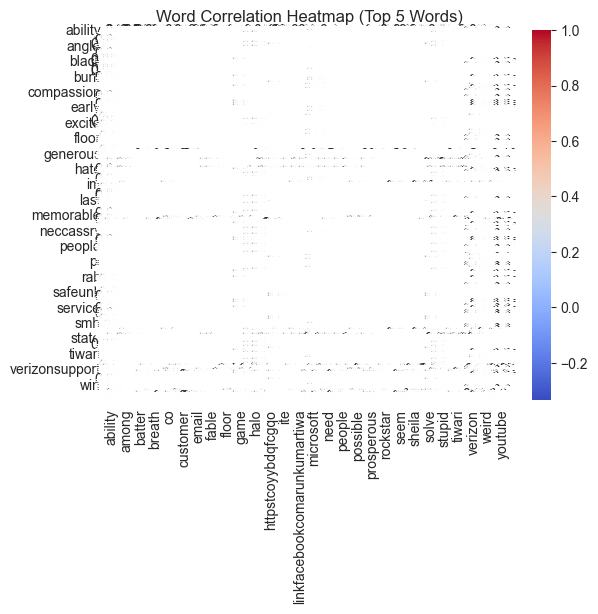

In [31]:
corr = cov.corr()

# Heatmap
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Word Correlation Heatmap (Top 5 Words)")
plt.show()

Truncated SVD - for dimensionality reduction in sparse matrices.

In [73]:
svd = TruncatedSVD(n_components=100, random_state=42)

In [74]:
X_reduced = svd.fit_transform(X_normalized)

Logistic Regression

In [75]:
model = LogisticRegression(class_weight='balanced', max_iter=1000)
model.fit(X_reduced, train_df['sentiment'])

LogisticRegression(class_weight='balanced', max_iter=1000)

In [76]:
def bow_method(df,vectorizer, normalizer, svd):
    # Work on a copy to prevent changing the original DataFrame
    df_copy = df.copy()
    df_copy.drop(['sentiment'], axis=1, inplace=True)
    df_copy.drop(['id'], axis=1, inplace=True)
    # --- Make sure to use df_copy for all subsequent steps inside this function ---
    df_copy['text'] = df_copy['text'].apply(clean)
    X_bow = vectorizer.transform(df_copy['text'])
    categorical_feature_0 = target_encoder.transform(df_copy['title'].values.reshape(-1, 1))
    X_bow = hstack([categorical_feature_0, X_bow])
    X_normal = normalizer.transform(X_bow)
    X_bow_combo = svd.transform(X_normal)
    return X_bow_combo

In [77]:
X_bow_test_combo=bow_method(val_df,vectorizer,normalizer,svd)

In [78]:
y_bow_pred = model.predict(X_bow_test_combo)

In [79]:
print("Val: ",len(bow_test['title'].unique()))
print("Train: ",len(bow_train['title'].unique()))

Val:  10
Train:  14


In [80]:
print(f"Train BoW shape: {X_bow_combo.shape}")  # Expected: (n_samples, 222)
print(f"Test BoW shape: {X_bow_test_combo.shape}")    # Expected: (n_samples, 222)

Train BoW shape: (73996, 34527)
Test BoW shape: (1000, 100)


In [81]:
print(y_bow_pred)

['Irrelevant' 'Neutral' 'Neutral' 'Neutral' 'Neutral' 'Negative'
 'Positive' 'Irrelevant' 'Positive' 'Negative' 'Negative' 'Positive'
 'Negative' 'Irrelevant' 'Negative' 'Neutral' 'Positive' 'Negative'
 'Neutral' 'Neutral' 'Positive' 'Positive' 'Irrelevant' 'Neutral'
 'Neutral' 'Irrelevant' 'Negative' 'Irrelevant' 'Irrelevant' 'Neutral'
 'Neutral' 'Irrelevant' 'Neutral' 'Positive' 'Negative' 'Positive'
 'Neutral' 'Positive' 'Positive' 'Negative' 'Negative' 'Irrelevant'
 'Positive' 'Neutral' 'Positive' 'Irrelevant' 'Irrelevant' 'Neutral'
 'Irrelevant' 'Negative' 'Positive' 'Negative' 'Negative' 'Positive'
 'Irrelevant' 'Positive' 'Positive' 'Negative' 'Negative' 'Positive'
 'Negative' 'Positive' 'Positive' 'Irrelevant' 'Negative' 'Neutral'
 'Positive' 'Irrelevant' 'Positive' 'Negative' 'Positive' 'Neutral'
 'Positive' 'Neutral' 'Positive' 'Neutral' 'Negative' 'Irrelevant'
 'Negative' 'Neutral' 'Neutral' 'Positive' 'Positive' 'Negative'
 'Positive' 'Irrelevant' 'Negative' 'Negative' 'Pos

In [83]:
val_df['LR Model Predictions'] = y_bow_pred

In [84]:
val_df['Real Labels'] = y_real_bow

In [85]:
val_df

,id,title,sentiment,text,LR Model Predictions,Real Labels
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...,Irrelevant,Irrelevant
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...,Neutral,Neutral
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...,Neutral,Negative
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,...",Neutral,Negative
4,4433,Google,Neutral,Now the President is slapping Americans in the...,Neutral,Neutral
...,...,...,...,...,...,...
995,4891,GrandTheftAuto(GTA),Irrelevant,⭐️ Toronto is the arts and culture capital of ...,Irrelevant,NaN
996,4359,CS-GO,Irrelevant,tHIS IS ACTUALLY A GOOD MOVE TOT BRING MORE VI...,Irrelevant,NaN
997,2652,Borderlands,Positive,Today sucked so it’s time to drink wine n play...,Positive,NaN
998,8069,Microsoft,Positive,Bought a fraction of Microsoft today. Small wins.,Neutral,NaN


Decision Tree

In [130]:
clf = DecisionTreeClassifier(criterion='gini', max_depth=None, random_state=42)

In [131]:
clf.fit(X_reduced, bow_train['sentiment'])

DecisionTreeClassifier(random_state=42)

In [132]:
y_pred_dt = clf.predict(X_bow_test_combo)

In [133]:
bow_test['Decision Tree Prediction'] = y_pred_dt

C:\Users\nnn866470\AppData\Local\Temp\ipykernel_19540\2384182960.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bow_test['Decision Tree Prediction'] = y_pred_dt


In [134]:
bow_test

,title,text,LR Model Predictions,Real Labels,Decision Tree Prediction
0,Facebook,mention facebook struggle motivation go run da...,Positive,Irrelevant,Positive
1,Amazon,bbc news amazon bos jeff bezos reject claim co...,Neutral,Neutral,Positive
2,Microsoft,microsoft pay word function poorly samsungus c...,Irrelevant,Negative,Irrelevant
3,CS-GO,csgo matchmaking full closet hack truly awful ...,Irrelevant,Negative,Irrelevant
4,Google,president slap american face really commit unl...,Irrelevant,Neutral,Irrelevant
5,FIFA,hi eahelp ive madeleine mccann cellar past yea...,Negative,Negative,Irrelevant
6,MaddenNFL,thank eamaddennfl new te austin hooper orange ...,Irrelevant,Positive,Neutral
7,TomClancysRainbowSix,rocket league sea thief rainbow six siege love...,Irrelevant,Positive,Irrelevant
8,AssassinsCreed,as still kneedeep assassin creed odyssey way a...,Irrelevant,Positive,Irrelevant
9,CallOfDuty,fix jesus please fix world go playstation askp...,Irrelevant,Negative,Irrelevant


Random Forest

In [135]:
rf_model = RandomForestClassifier(n_estimators=5, random_state=42)

In [136]:
rf_model.fit(X_reduced, bow_train['sentiment'])

RandomForestClassifier(n_estimators=5, random_state=42)

In [137]:
y_pred_rf = rf_model.predict(X_bow_test_combo)

In [138]:
bow_test['Random Forest Predictions'] = y_pred_rf

C:\Users\nnn866470\AppData\Local\Temp\ipykernel_19540\3278068601.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bow_test['Random Forest Predictions'] = y_pred_rf


In [139]:
bow_test.head()

,title,text,LR Model Predictions,Real Labels,Decision Tree Prediction,Random Forest Predictions
0,Facebook,mention facebook struggle motivation go run da...,Positive,Irrelevant,Positive,Positive
1,Amazon,bbc news amazon bos jeff bezos reject claim co...,Neutral,Neutral,Positive,Irrelevant
2,Microsoft,microsoft pay word function poorly samsungus c...,Irrelevant,Negative,Irrelevant,Irrelevant
3,CS-GO,csgo matchmaking full closet hack truly awful ...,Irrelevant,Negative,Irrelevant,Irrelevant
4,Google,president slap american face really commit unl...,Irrelevant,Neutral,Irrelevant,Irrelevant


Naive Bayes

In [140]:
model_nb = MultinomialNB()

In [142]:
model_nb.fit(X_bow_combo, bow_train['sentiment'])

MultinomialNB()

In [ ]:
y_pred_nb = model_nb.predict(X_bow_test_combo)

In [ ]:
y_pred_nb

In [ ]:
bow_test['Naive Bayes'] = y_pred_nb

In [ ]:
bow_test

## Evaluation

Evaluating Logistic Regression

In [88]:
from sklearn.metrics import precision_score
import pandas as pd

# Get the class labels in the correct order from the trained model
class_labels = model.classes_

# Calculate precision scores
precision_per_class_bow = precision_score(y_real_bow, y_bow_pred, average=None, zero_division=0)

# Create a DataFrame to display the results clearly
precision_df = pd.DataFrame({
    'Class': class_labels,
    'Precision': precision_per_class_bow
})

print("Precision Per Class:")
print(precision_df)

Precision Per Class:
        Class  Precision
0  Irrelevant   0.401639
1    Negative   0.547893
2     Neutral   0.517510
3    Positive   0.588235


In [89]:
from sklearn.metrics import classification_report

print(classification_report(y_real_bow, y_bow_pred))


              precision    recall  f1-score   support

  Irrelevant       0.40      0.57      0.47       172
    Negative       0.55      0.54      0.54       266
     Neutral       0.52      0.47      0.49       285
    Positive       0.59      0.51      0.54       277

    accuracy                           0.51      1000
   macro avg       0.51      0.52      0.51      1000
weighted avg       0.53      0.51      0.52      1000



Evaluating Decision Tree

In [146]:
print("Accuracy:", accuracy_score(y_real_bow, y_pred_dt))
print("\nClassification Report:\n", classification_report(y_real_bow, y_pred_dt))

Accuracy: 0.0

Classification Report:
               precision    recall  f1-score   support

  Irrelevant       0.00      0.00      0.00       1.0
    Negative       0.00      0.00      0.00       4.0
     Neutral       0.00      0.00      0.00       2.0
    Positive       0.00      0.00      0.00       3.0

    accuracy                           0.00      10.0
   macro avg       0.00      0.00      0.00      10.0
weighted avg       0.00      0.00      0.00      10.0



C:\Users\nnn866470\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\nnn866470\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\nnn866470\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

Evaluating Random Forest

In [147]:
print("Accuracy:", accuracy_score(y_real_bow, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_real_bow, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_real_bow, y_pred_rf))

Accuracy: 0.0

Classification Report:
               precision    recall  f1-score   support

  Irrelevant       0.00      0.00      0.00       1.0
    Negative       0.00      0.00      0.00       4.0
     Neutral       0.00      0.00      0.00       2.0
    Positive       0.00      0.00      0.00       3.0

    accuracy                           0.00      10.0
   macro avg       0.00      0.00      0.00      10.0
weighted avg       0.00      0.00      0.00      10.0

Confusion Matrix:
 [[0 0 0 1]
 [2 0 0 2]
 [2 0 0 0]
 [3 0 0 0]]


C:\Users\nnn866470\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\nnn866470\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\nnn866470\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

Evaluating Naive Bayes

In [ ]:
print("Accuracy:", accuracy_score(y_real_bow, y_pred_nb))
print(classification_report(y_real_bow, y_pred_nb))

Serialization - vectorizer and model

In [90]:
joblib.dump(model, 'sentiment_model.pkl')
joblib.dump(vectorizer, 'count_vectorizer.pkl')
joblib.dump(target_encoder, 'target_encoder.pkl')

['target_encoder.pkl']

In [92]:
joblib.dump(svd, 'svd_transformer.pkl')

['svd_transformer.pkl']

In [93]:
import os
print("Current working directory:", os.getcwd())

Current working directory: C:\Users\nnn866470\PycharmProjects\Text-Sentiment-Classifier
